In [ ]:
!pip install vit_keras -q

In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import sys
import random
import warnings
import numpy as np
import pandas as pd
from time import time
from itertools import chain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (
    Dense, Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate,
    Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D,
    BatchNormalization, SeparableConv2D, Flatten )

from sklearn.metrics import classification_report
%matplotlib inline

from vit_keras import  vit, utils

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = "gdrive/My Drive/Colab Notebooks/AML Project/chest_xray_reshuffle/"

In [ ]:
#reading required files
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image dimensions expected by MobileNetV2
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow training images in batches using tf.keras.preprocessing.image.ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # or 'categorical' if you have more than two classes
)

# Flow validation images in batches using tf.keras.preprocessing.image.ImageDataGenerator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Flow test images in batches using tf.keras.preprocessing.image.ImageDataGenerator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4686 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, Callback
from tensorflow.keras import backend as K
from keras_tuner import RandomSearch

In [ ]:
# Define metrics
precision_metric = Precision()
recall_metric = Recall()
auc_metric = AUC()
auc_pr_metric = AUC(curve='PR')

def F1Score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1_score

# Callbacks Setup
checkpoint = ModelCheckpoint('model-best-new-data.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=8)
#csv_logger = CSVLogger('training_log-new-data.csv')

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        precision_metric.reset_states()
        recall_metric.reset_states()
        auc_metric.reset_states()
        auc_pr_metric.reset_states()



In [ ]:
# Include the ResetStatesCallback in your callbacks list
reset_states_callback = ResetStatesCallback()

In [ ]:


# Model Setup with ViT
def build_model(hp):
    model = vit.vit_b16(
        image_size=224,
        activation='sigmoid',  # Change activation based on your task
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=1  # Assuming binary classification, adjust if needed
    )

    # Add Dense layers
    model = tf.keras.Sequential([
        model,
        layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            precision_metric,
            recall_metric,
            F1Score,
            auc_metric,
            auc_pr_metric
        ]
    )

    return model


In [ ]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='pneumonia_detection-new-data'
)

In [ ]:
# Run the hyperparameter search
tuner.search(train_generator, epochs=3, validation_data=validation_generator, callbacks=[checkpoint, early_stopping, reset_states_callback]) #csv_logger removed


Trial 5 Complete [00h 11m 20s]
val_accuracy: 0.7299145460128784

Best val_accuracy So Far: 0.9059829115867615
Total elapsed time: 01h 07m 02s


In [ ]:
# Get the best hyperparameters
best_hparams = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("Best Hyperparameters:")
print(best_hparams)

Best Hyperparameters:
{'units': 384, 'dropout': 0.2, 'learning_rate': 0.00032699677404287816}


In [ ]:
# Get the best hyperparameters
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hparams = best_trial.hyperparameters.values
print("Best Hyperparameters:")
print(best_hparams)

Best Hyperparameters:
{'units': 384, 'dropout': 0.2, 'learning_rate': 0.00032699677404287816}


In [ ]:
# Build the final model using the best hyperparameters
final_model_test = tuner.hypermodel.build(best_trial.hyperparameters)
final_model_test.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy', precision_metric,
            recall_metric,
            F1Score,
            auc_metric,
            auc_pr_metric])

In [ ]:
# Train the final model
final_history_test = final_model_test.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
147/147 [==============================] - 211s 1s/step - loss: 0.2471 - accuracy: 0.8939 - precision: 0.9322 - recall: 0.9216 - F1Score: 0.9293 - auc: 0.9510 - auc_1: 0.9801 - val_loss: 0.3727 - val_accuracy: 0.8274 - val_precision: 0.8826 - val_recall: 0.8806 - val_F1Score: 0.8761 - val_auc: 0.8846 - val_auc_1: 0.9510
Epoch 2/10
147/147 [==============================] - 209s 1s/step - loss: 0.2587 - accuracy: 0.8854 - precision: 0.9299 - recall: 0.9117 - F1Score: 0.9280 - auc: 0.9460 - auc_1: 0.9781 - val_loss: 0.4517 - val_accuracy: 0.8000 - val_precision: 0.8856 - val_recall: 0.8337 - val_F1Score: 0.8561 - val_auc: 0.8491 - val_auc_1: 0.9281
Epoch 3/10
147/147 [==============================] - 209s 1s/step - loss: 0.2390 - accuracy: 0.9010 - precision: 0.9386 - recall: 0.9248 - F1Score: 0.9299 - auc: 0.9551 - auc_1: 0.9830 - val_loss: 0.3814 - val_accuracy: 0.8359 - val_precision: 0.9066 - val_recall: 0.8642 - val_F1Score: 0.8851 - val_auc: 0.8979 - val_auc_1: 0.9578
E

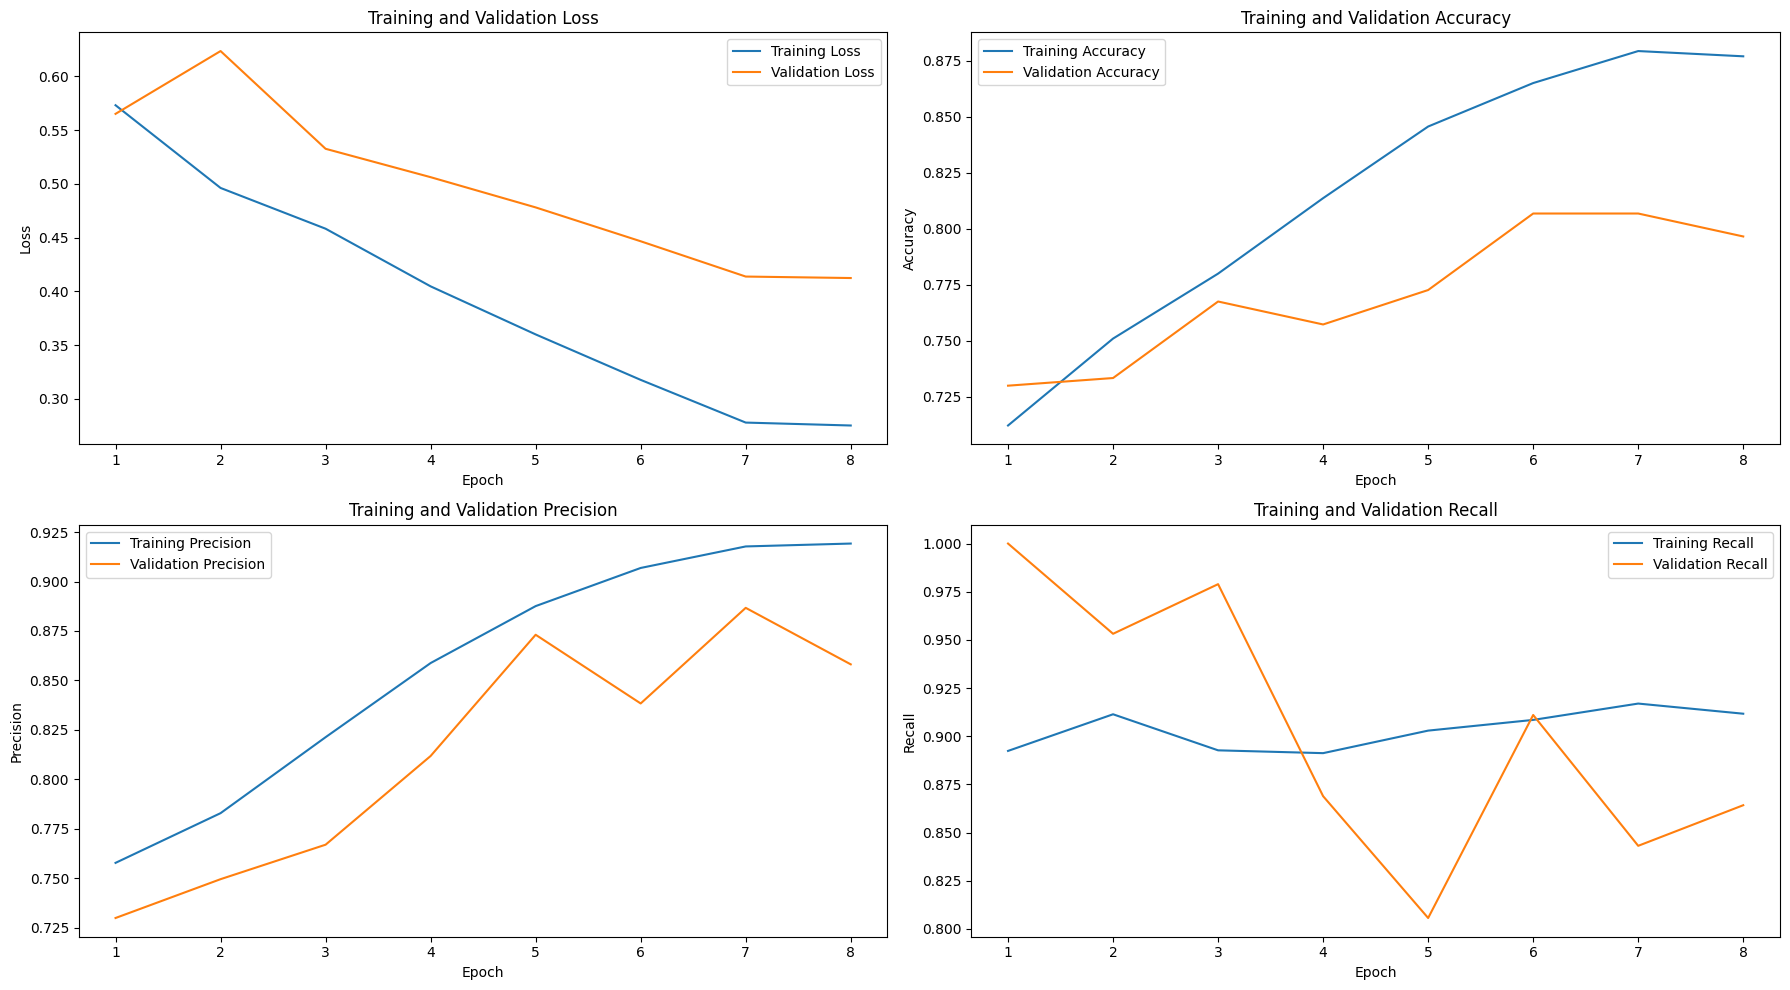

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object from model.fit()
epochs = range(1, len(final_history_test.history['loss']) + 1)

plt.figure(figsize=(18, 10))

# Plotting Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, final_history_test.history['loss'], label='Training Loss')
plt.plot(epochs, final_history_test.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, final_history_test.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, final_history_test.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Plotting Training and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, final_history_test.history['precision'], label='Training Precision')
plt.plot(epochs, final_history_test.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.xticks(epochs)
plt.legend()

# Plotting Training and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, final_history_test.history['recall'], label='Training Recall')
plt.plot(epochs, final_history_test.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.xticks(epochs)
plt.legend()

# Add similar sections for other metrics like F1 Score, AUC, etc., replacing 'METRIC_NAME' with actual metric names

plt.tight_layout()
plt.show()
